In [4]:
path = "/kaggle/input/adobe-fivek"

In [5]:
import tensorflow as tf
import pandas as pd
import os

# Define paths
raw_dir = "/kaggle/input/adobe-fivek/raw"
expertA_dir = "/kaggle/input/adobe-fivek/a"

# Get sorted lists of filenames
raw_images = sorted(os.listdir(raw_dir))
expertA_images = sorted(os.listdir(expertA_dir))

# Create a DataFrame mapping input (RAW) to output (Expert-A)
df = pd.DataFrame({
    "raw_image": [os.path.join(raw_dir, img) for img in raw_images],
    "expertA_image": [os.path.join(expertA_dir, img) for img in expertA_images]
})

print(df.head())  # View dataset structure


2025-04-16 17:10:25.744921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744823426.028351      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744823426.103940      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


                                           raw_image  \
0  /kaggle/input/adobe-fivek/raw/a0001-jmac_DSC14...   
1    /kaggle/input/adobe-fivek/raw/a0002-dgw_005.jpg   
2  /kaggle/input/adobe-fivek/raw/a0003-NKIM_MG_81...   
3  /kaggle/input/adobe-fivek/raw/a0004-jmac_MG_13...   
4  /kaggle/input/adobe-fivek/raw/a0005-jn_2007_05...   

                                       expertA_image  
0  /kaggle/input/adobe-fivek/a/a0001-jmac_DSC1459...  
1      /kaggle/input/adobe-fivek/a/a0002-dgw_005.jpg  
2  /kaggle/input/adobe-fivek/a/a0003-NKIM_MG_8178...  
3  /kaggle/input/adobe-fivek/a/a0004-jmac_MG_1384...  
4  /kaggle/input/adobe-fivek/a/a0005-jn_2007_05_1...  


In [6]:
# Image size for resizing
IMG_SIZE = (512, 512)

# Function to load and preprocess images
def load_image(input_path, output_path):
    input_image = tf.io.read_file(input_path)
    input_image = tf.image.decode_jpeg(input_image, channels=3)
    input_image = tf.image.resize(input_image, IMG_SIZE)
    input_image = input_image / 255.0  # Normalize to [0,1]

    output_image = tf.io.read_file(output_path)
    output_image = tf.image.decode_jpeg(output_image, channels=3)
    output_image = tf.image.resize(output_image, IMG_SIZE)
    output_image = output_image / 255.0  # Normalize to [0,1]

    return input_image, output_image

# Convert DataFrame to TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((df["raw_image"].values, df["expertA_image"].values))

# Load and preprocess images
dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

# Batch and shuffle for training
BATCH_SIZE = 16
dataset = dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Test loading one batch
for raw_img, expertA_img in dataset.take(1):
    print(raw_img.shape, expertA_img.shape)  # Should be (batch_size, 512, 512, 3)


I0000 00:00:1744823464.364039      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744823464.364750      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


(16, 512, 512, 3) (16, 512, 512, 3)


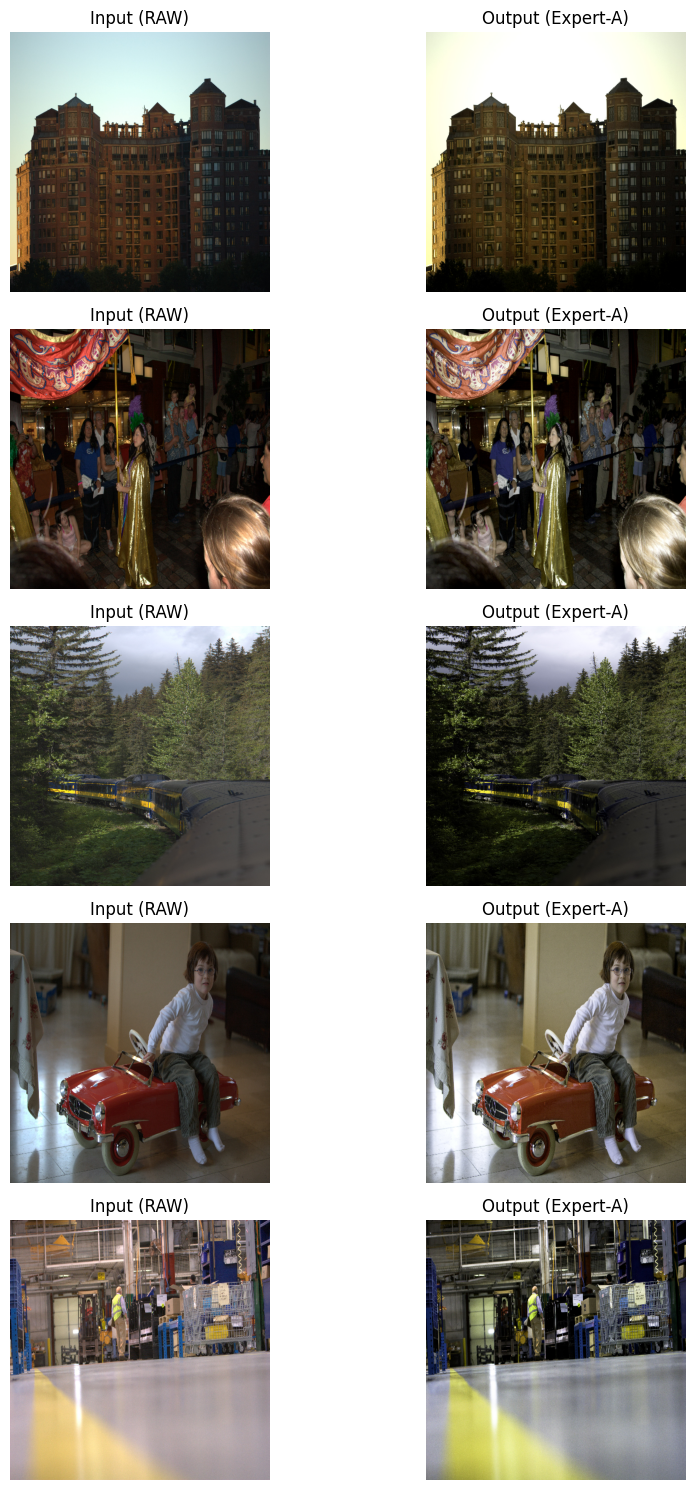

In [7]:
import matplotlib.pyplot as plt

# Take one batch from dataset
raw_imgs, expertA_imgs = next(iter(dataset))

# Convert tensors to numpy arrays
raw_imgs = raw_imgs.numpy()
expertA_imgs = expertA_imgs.numpy()

# Number of samples to display
num_samples = 5

# Plot input (RAW) and output (Expert-A) side by side
fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 3))

for i in range(num_samples):
    # Show input (RAW image)
    axes[i, 0].imshow(raw_imgs[i])
    axes[i, 0].axis("off")
    axes[i, 0].set_title("Input (RAW)")

    # Show output (Expert-A enhanced image)
    axes[i, 1].imshow(expertA_imgs[i])
    axes[i, 1].axis("off")
    axes[i, 1].set_title("Output (Expert-A)")

plt.tight_layout()
plt.show()


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
# import tensorflow_model_optimization as tfmot  # Uncomment if you wish to use pruning

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = keras.Sequential()
    # Lightweight: using SeparableConv2D instead of Conv2D
    result.add(layers.SeparableConv2D(filters, size, strides=2, padding='same',
                                      depthwise_initializer=initializer,
                                      pointwise_initializer=initializer,
                                      use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def build_generator():
    inputs = layers.Input(shape=[512, 512, 3])
    
    # Adjusted filter counts for a lightweight model
    down_stack = [
        downsample(32, 4, apply_batchnorm=False),  # 512 -> 256
        downsample(64, 4),                          # 256 -> 128
        downsample(128, 4),                         # 128 -> 64
        downsample(256, 4),                         # 64 -> 32
        downsample(256, 4),                         # 32 -> 16
        downsample(256, 4),                         # 16 -> 8
        downsample(256, 4),                         # 8 -> 4
        downsample(256, 4),                         # 4 -> 2
    ]
    
    up_stack = [
        upsample(256, 4, apply_dropout=True),       # 2 -> 4
        upsample(256, 4, apply_dropout=True),       # 4 -> 8
        upsample(256, 4, apply_dropout=True),       # 8 -> 16
        upsample(256, 4),                           # 16 -> 32
        upsample(128, 4),                           # 32 -> 64
        upsample(64, 4),                            # 64 -> 128
        upsample(32, 4),                            # 128 -> 256
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                                  kernel_initializer=initializer, activation='tanh')  # 256 -> 512
    
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    
    x = last(x)
    
    return keras.Model(inputs=inputs, outputs=x)

generator = build_generator()
generator.summary()

def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = layers.Input(shape=[512, 512, 3], name='input_image')
    tar = layers.Input(shape=[512, 512, 3], name='target_image')
    
    x = layers.Concatenate()([inp, tar])
    
    # Lightweight discriminator: reduced filters for downsampling
    down1 = downsample(32, 4, apply_batchnorm=False)(x)  # 512 -> 256
    down2 = downsample(64, 4)(down1)                       # 256 -> 128
    down3 = downsample(128, 4)(down2)                      # 128 -> 64
    
    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(256, 4, strides=1,
                         kernel_initializer=initializer, use_bias=False)(zero_pad1)
    
    batchnorm = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm)
    
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)
    
    return keras.Model(inputs=[inp, tar], outputs=last)

discriminator = build_discriminator()
discriminator.summary()

LAMBDA = 100  # Weight for L1 loss

loss_object = keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target, lambda_weight):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    return gan_loss + lambda_weight * l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    return real_loss + generated_loss

HYPERPARAM_BOUNDS = {
    'learning_rate': (1e-5, 1e-3),
    'lambda': (10, 200),
    'batch_size': (2, 8)
}

def sample_hyperparams():
    return {
        'learning_rate': np.random.uniform(*HYPERPARAM_BOUNDS['learning_rate']),
        'lambda': np.random.uniform(*HYPERPARAM_BOUNDS['lambda']),
        'batch_size': int(np.random.randint(*HYPERPARAM_BOUNDS['batch_size']))
    }

def hyperparam_fitness(hyperparams, raw_img, expertA_img):
    learning_rate = hyperparams['learning_rate']
    lambda_weight = hyperparams['lambda']
    batch_size = hyperparams['batch_size']

    generator = build_generator()
    discriminator = build_discriminator()
    gen_opt = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    disc_opt = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    dataset = tf.data.Dataset.from_tensor_slices((raw_img, expertA_img)).batch(batch_size)
    for epoch in range(3):  # Train for a few epochs per hyperparam
        for batch_in, batch_out in dataset:
            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                gen_out = generator(batch_in, training=True)
                disc_real = discriminator([batch_in, batch_out], training=True)
                disc_fake = discriminator([batch_in, gen_out], training=True)

                gen_loss = generator_loss(disc_fake, gen_out, batch_out, lambda_weight)
                disc_loss = discriminator_loss(disc_real, disc_fake)

            gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            gen_opt.apply_gradients(zip(gen_grads, generator.trainable_variables))
            disc_opt.apply_gradients(zip(disc_grads, discriminator.trainable_variables))



    val_input, val_target = raw_img[:2], expertA_img[:2]
    gen_out = generator(val_input, training=False)
    mae = tf.reduce_mean(tf.abs(val_target - gen_out)).numpy()
    return mae

def pso_hyperparam_optimization(raw_img, expertA_img, swarm_size=5, iterations=5):
    swarm = [sample_hyperparams() for _ in range(swarm_size)]
    velocities = [{} for _ in range(swarm_size)]
    personal_best = swarm.copy()
    personal_best_scores = [hyperparam_fitness(p, raw_img, expertA_img) for p in swarm]

    best_idx = np.argmin(personal_best_scores)
    global_best = swarm[best_idx]
    global_best_score = personal_best_scores[best_idx]

    for it in range(iterations):
        for i in range(swarm_size):
            for param in swarm[i]:
                r1, r2 = np.random.rand(), np.random.rand()
                cognitive = r1 * (personal_best[i][param] - swarm[i][param])
                social = r2 * (global_best[param] - swarm[i][param])
                velocities[i][param] = 0.7 * velocities[i].get(param, 0) + 1.5 * (cognitive + social)
                swarm[i][param] += velocities[i][param]
                lb, ub = HYPERPARAM_BOUNDS[param]
                swarm[i][param] = np.clip(swarm[i][param], lb, ub)
                if param == 'batch_size':
                    swarm[i][param] = int(swarm[i][param])

            score = hyperparam_fitness(swarm[i], raw_img, expertA_img)
            if score < personal_best_scores[i]:
                personal_best[i] = swarm[i].copy()
                personal_best_scores[i] = score
                if score < global_best_score:
                    global_best = swarm[i].copy()
                    global_best_score = score
        print(f"[Iter {it+1}] Best MAE: {global_best_score:.4f} with {global_best}")

    return global_best

best_hyperparams = pso_hyperparam_optimization(raw_img, expertA_img, swarm_size=4, iterations=5)


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 256, 256, 32)   │            144 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 128, 128, 64)   │          2,816 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_2 (Sequential) │ (None, 64, 64, 128)    │          9,728 │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_3 (Sequential) │ (None, 32, 32, 256)    │         35,840 │ sequential_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_4 (Sequential) │ (None, 16, 16, 256)    │         70,656 │ sequential_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_5 (Sequential) │ (None, 8, 8, 256)      │         70,656 │ sequential_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_6 (Sequential) │ (None, 4, 4, 256)      │         70,656 │ sequential_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_7 (Sequential) │ (None, 2, 2, 256)      │         70,656 │ sequential_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_8 (Sequential) │ (None, 4, 4, 256)      │      1,049,600 │ sequential_7[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 4, 4, 512)      │              0 │ sequential_8[0][0],    │
│                           │                        │                │ sequential_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_9 (Sequential) │ (None, 8, 8, 256)      │      2,098,176 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 8, 8, 512)      │              0 │ sequential_9[0][0],    │
│ (Concatenate)             │                        │                │ sequential_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_10             │ (None, 16, 16, 256)    │      2,098,176 │ concatenate_1[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 16, 16, 512)    │              0 │ sequential_10[0][0],   │
│ (Concatenate)             │                        │                │ sequential_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_11             │ (None, 32, 32, 256)    │      2,098,176 │ concatenate_2[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 32, 32, 512)    │              0 │ sequential_11[0][0],   │
│ (Concatenate)        

 Total params: 9,055,507 (34.54 MB)

 Trainable params: 9,050,067 (34.52 MB)

 Non-trainable params: 5,440 (21.25 KB)

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_image (InputLayer) │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 512, 512, 6)    │              0 │ input_image[0][0],     │
│ (Concatenate)             │                        │                │ target_image[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_15             │ (None, 256, 256, 32)   │            288 │ concatenate_7[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_16             │ (None, 128, 128, 64)   │          2,816 │ sequential_15[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_17             │ (None, 64, 64, 128)    │          9,728 │ sequential_16[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 66, 66, 128)    │              0 │ sequential_17[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 63, 63, 256)    │        524,288 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 63, 63, 256)    │          1,024 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_11            │ (None, 63, 63, 256)    │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 65, 65, 256)    │              0 │ leaky_re_lu_11[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 62, 62, 1)      │          4,097 │ zero_padding2d_1[0][0] │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 542,241 (2.07 MB)

 Trainable params: 541,345 (2.07 MB)

 Non-trainable params: 896 (3.50 KB)

I0000 00:00:1744823715.314290      31 cuda_dnn.cc:529] Loaded cuDNN version 90300


[Iter 1] Best MAE: 0.3661 with {'learning_rate': 0.0004369561743985422, 'lambda': 22.474599846167596, 'batch_size': 4}
[Iter 2] Best MAE: 0.2989 with {'learning_rate': 0.001, 'lambda': 16.29053044072011, 'batch_size': 2}
[Iter 3] Best MAE: 0.2903 with {'learning_rate': 0.001, 'lambda': 22.877451883866, 'batch_size': 2}
[Iter 4] Best MAE: 0.2903 with {'learning_rate': 0.001, 'lambda': 22.877451883866, 'batch_size': 2}
[Iter 5] Best MAE: 0.2903 with {'learning_rate': 0.001, 'lambda': 22.877451883866, 'batch_size': 2}


In [9]:
#GAN-D

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
# import tensorflow_model_optimization as tfmot  # Uncomment if you wish to use pruning

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = keras.Sequential()
    # Lightweight: using SeparableConv2D instead of Conv2D
    result.add(layers.SeparableConv2D(filters, size, strides=2, padding='same',
                                      depthwise_initializer=initializer,
                                      pointwise_initializer=initializer,
                                      use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def build_generator():
    inputs = layers.Input(shape=[512, 512, 3])
    
    # Adjusted filter counts for a lightweight model
    down_stack = [
        downsample(32, 4, apply_batchnorm=False),  # 512 -> 256
        downsample(64, 4),                          # 256 -> 128
        downsample(128, 4),                         # 128 -> 64
        downsample(256, 4),                         # 64 -> 32
        downsample(256, 4),                         # 32 -> 16
        downsample(256, 4),                         # 16 -> 8
        downsample(256, 4),                         # 8 -> 4
        downsample(256, 4),                         # 4 -> 2
    ]
    
    up_stack = [
        upsample(256, 4, apply_dropout=True),       # 2 -> 4
        upsample(256, 4, apply_dropout=True),       # 4 -> 8
        upsample(256, 4, apply_dropout=True),       # 8 -> 16
        upsample(256, 4),                           # 16 -> 32
        upsample(128, 4),                           # 32 -> 64
        upsample(64, 4),                            # 64 -> 128
        upsample(32, 4),                            # 128 -> 256
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                                  kernel_initializer=initializer, activation='tanh')  # 256 -> 512
    
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    
    x = last(x)
    
    return keras.Model(inputs=inputs, outputs=x)

generator = build_generator()
generator.summary()

def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = layers.Input(shape=[512, 512, 3], name='input_image')
    tar = layers.Input(shape=[512, 512, 3], name='target_image')
    
    x = layers.Concatenate()([inp, tar])
    
    # Lightweight discriminator: reduced filters for downsampling
    down1 = downsample(32, 4, apply_batchnorm=False)(x)  # 512 -> 256
    down2 = downsample(64, 4)(down1)                       # 256 -> 128
    down3 = downsample(128, 4)(down2)                      # 128 -> 64
    
    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(256, 4, strides=1,
                         kernel_initializer=initializer, use_bias=False)(zero_pad1)
    
    batchnorm = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm)
    
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)
    
    return keras.Model(inputs=[inp, tar], outputs=last)

discriminator = build_discriminator()
discriminator.summary()

LAMBDA = best_hyperparams['lambda']  # Weight for L1 loss

loss_object = keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_loss = gan_loss + (LAMBDA * l1_loss)
    return total_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    fake_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_loss = real_loss + fake_loss
    return total_loss

generator_optimizer = keras.optimizers.Adam(best_hyperparams['learning_rate'], beta_1=0.5)
discriminator_optimizer = keras.optimizers.Adam(best_hyperparams['learning_rate'], beta_1=0.5)

@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        
        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

EPOCHS = 1  # Adjust the number of epochs as needed

# Assume 'dataset' is a tf.data.Dataset yielding (raw_img, expertA_img) pairs
for epoch in range(EPOCHS):
    for raw_img, expertA_img in dataset:
        gen_loss, disc_loss = train_step(raw_img, expertA_img)
    print(f"Epoch {epoch+1}/{EPOCHS} - Gen Loss: {gen_loss:.4f}, Disc Loss: {disc_loss:.4f}") 


Model: "functional_515"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_475           │ (None, 512, 512, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_450            │ (None, 256, 256, 32)   │            144 │ input_layer_475[0][0]  │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_451            │ (None, 128, 128, 64)   │          2,816 │ sequential_450[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_452            │ (None, 64, 64, 128)    │          9,728 │ sequential_451[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_453            │ (None, 32, 32, 256)    │         35,840 │ sequential_452[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_454            │ (None, 16, 16, 256)    │         70,656 │ sequential_453[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_455            │ (None, 8, 8, 256)      │         70,656 │ sequential_454[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_456            │ (None, 4, 4, 256)      │         70,656 │ sequential_455[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_457            │ (None, 2, 2, 256)      │         70,656 │ sequential_456[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_458            │ (None, 4, 4, 256)      │      1,049,600 │ sequential_457[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_200           │ (None, 4, 4, 512)      │              0 │ sequential_458[0][0],  │
│ (Concatenate)             │                        │                │ sequential_456[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_459            │ (None, 8, 8, 256)      │      2,098,176 │ concatenate_200[0][0]  │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_201           │ (None, 8, 8, 512)      │              0 │ sequential_459[0][0],  │
│ (Concatenate)             │                        │                │ sequential_455[0][0]   │
├──────────────────────

 Total params: 9,055,507 (34.54 MB)

 Trainable params: 9,050,067 (34.52 MB)

 Non-trainable params: 5,440 (21.25 KB)

Model: "functional_519"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_image (InputLayer) │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_207           │ (None, 512, 512, 6)    │              0 │ input_image[0][0],     │
│ (Concatenate)             │                        │                │ target_image[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_465            │ (None, 256, 256, 32)   │            288 │ concatenate_207[0][0]  │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_466            │ (None, 128, 128, 64)   │          2,816 │ sequential_465[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_467            │ (None, 64, 64, 128)    │          9,728 │ sequential_466[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_50         │ (None, 66, 66, 128)    │              0 │ sequential_467[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_50 (Conv2D)        │ (None, 63, 63, 256)    │        524,288 │ zero_padding2d_50[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_441   │ (None, 63, 63, 256)    │          1,024 │ conv2d_50[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_311           │ (None, 63, 63, 256)    │              0 │ batch_normalization_4… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_51         │ (None, 65, 65, 256)    │              0 │ leaky_re_lu_311[0][0]  │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_51 (Conv2D)        │ (None, 62, 62, 1)      │          4,097 │ zero_padding2d_51[0][… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 542,241 (2.07 MB)

 Trainable params: 541,345 (2.07 MB)

 Non-trainable params: 896 (3.50 KB)

E0000 00:00:1744824146.972507      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_515_1/sequential_458_1/dropout_75_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
E0000 00:00:1744824419.819506      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_515_1/sequential_458_1/dropout_75_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 1/1 - Gen Loss: 3.1747, Disc Loss: 1.4837


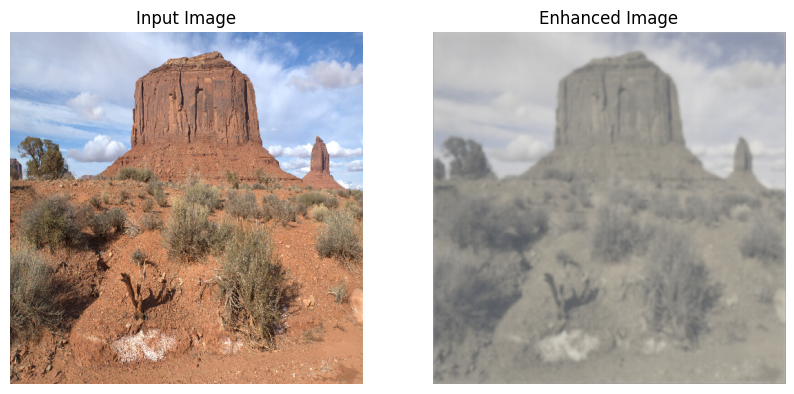

In [10]:
generator.save('saved_models/generator.h5')
discriminator.save('saved_models/discriminator.h5')

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image as keras_image

generator = tf.keras.models.load_model('saved_models/generator.h5')

# Function to load and preprocess the input image
def load_and_preprocess_image(img_path):
    img = keras_image.load_img(img_path, target_size=(512, 512))
    img = keras_image.img_to_array(img)
    img = (img / 127.5) - 1  # Scale to [-1, 1]
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to display input and output
def generate_and_show(generator, input_image_path):
    input_image = load_and_preprocess_image(input_image_path)
    prediction = generator(input_image, training=False)

    # Remove batch dimension and scale back to [0, 1]
    input_image = (input_image[0] + 1) / 2
    prediction = (prediction[0] + 1) / 2

    plt.figure(figsize=(10, 5))
    titles = ['Input Image', 'Enhanced Image']
    for i, img in enumerate([input_image, prediction]):
        plt.subplot(1, 2, i + 1)
        plt.title(titles[i])
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# Example usage
generate_and_show(generator, '/kaggle/input/adobe-fivek/raw/a0001-jmac_DSC1459.jpg')


Starting epoch 1/100
Epoch 1/100 - Gen Loss: 10.9257, Disc Loss: 1.5471

Starting epoch 2/100
Epoch 2/100 - Gen Loss: 12.0865, Disc Loss: 0.4962

Starting epoch 3/100
Epoch 3/100 - Gen Loss: 13.1177, Disc Loss: 1.2683

Starting epoch 4/100
Epoch 4/100 - Gen Loss: 10.0754, Disc Loss: 1.4358

Starting epoch 5/100
Epoch 5/100 - Gen Loss: 10.5224, Disc Loss: 1.3300

Starting epoch 6/100
Epoch 6/100 - Gen Loss: 10.5571, Disc Loss: 1.6493

Starting epoch 7/100
Epoch 7/100 - Gen Loss: 11.7506, Disc Loss: 2.3494

Starting epoch 8/100
Epoch 8/100 - Gen Loss: 11.5304, Disc Loss: 2.2196

Starting epoch 9/100
Epoch 9/100 - Gen Loss: 11.1347, Disc Loss: 2.2604

Starting epoch 10/100
Epoch 10/100 - Gen Loss: 11.0033, Disc Loss: 1.6516

Starting epoch 11/100
Epoch 11/100 - Gen Loss: 10.7427, Disc Loss: 1.5402

Starting epoch 12/100
Epoch 12/100 - Gen Loss: 10.8680, Disc Loss: 1.1819

Starting epoch 13/100
Epoch 13/100 - Gen Loss: 11.0047, Disc Loss: 0.9293

Starting epoch 14/100
Epoch 14/100 - Gen Lo

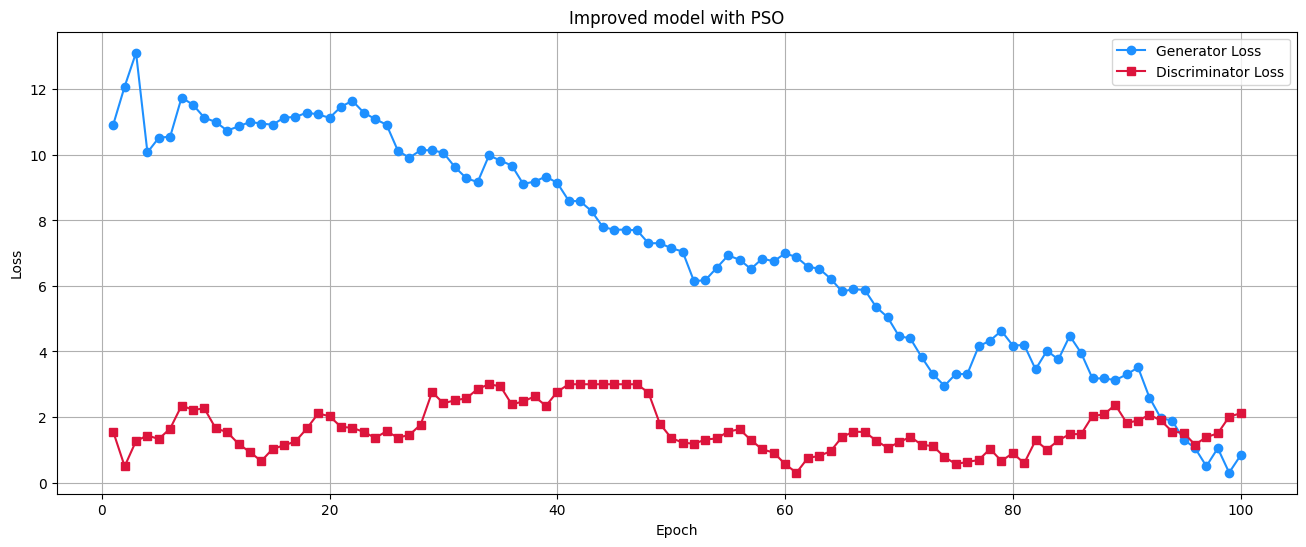

In [23]:
#PSO Implemented

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# ============================
# Utility functions for PSO
# ============================
def flatten_weights(weights):
    """Flatten list of weight arrays into one 1D numpy vector."""
    return np.concatenate([w.flatten() for w in weights])

def unflatten_weights(flat_vector, weight_shapes):
    """Convert a flat vector into a list of arrays with given shapes."""
    weights = []
    index = 0
    for shape in weight_shapes:
        size = np.prod(shape)
        weights.append(flat_vector[index:index+size].reshape(shape))
        index += size
    return weights

def evaluate_fitness(model, candidate_weights, x_val, y_val):
    """
    Evaluate fitness (loss) of a candidate weight configuration.
    Temporarily sets the model weights to candidate_weights,
    computes the mean absolute error on the given validation batch,
    and then restores the original weights.
    """
    original_weights = model.get_weights()
    model.set_weights(candidate_weights)
    gen_output = model(x_val, training=False)
    # Using MAE as fitness (the lower, the better)
    loss = np.mean(np.abs(y_val - gen_output.numpy()))
    model.set_weights(original_weights)
    return loss

def pso_optimize(model, x_val, y_val, swarm_size=5, iterations=20):
    """
    A simple Particle Swarm Optimization (PSO) routine to fine tune the
    generator's weights using a small validation batch.
    """
    # Get current weights and shape information.
    current_weights = model.get_weights()
    weight_shapes = [w.shape for w in current_weights]
    current_flat = flatten_weights(current_weights)
    dim = current_flat.size
    
    # Initialize swarm: each particle is a candidate weight vector.
    swarm = [current_flat + np.random.randn(dim) * 0.005 for _ in range(swarm_size)]
    velocities = [np.zeros(dim) for _ in range(swarm_size)]
    
    # Evaluate each particle.
    personal_best = list(swarm)
    personal_best_scores = [
        evaluate_fitness(model, unflatten_weights(p, weight_shapes), x_val, y_val)
        for p in swarm
    ]
    best_idx = np.argmin(personal_best_scores)
    global_best = swarm[best_idx].copy()
    global_best_score = personal_best_scores[best_idx]
    
    # PSO hyperparameters (tuned for this problem)
    inertia = 0.7
    cognitive_coeff = 1.5
    social_coeff = 1.5

    for it in range(iterations):
        for j in range(swarm_size):
            r1, r2 = np.random.rand(), np.random.rand()
            velocities[j] = (inertia * velocities[j] +
                             cognitive_coeff * r1 * (personal_best[j] - swarm[j]) +
                             social_coeff * r2 * (global_best - swarm[j]))
            swarm[j] = swarm[j] + velocities[j]
            # Evaluate new position.
            candidate_weights = unflatten_weights(swarm[j], weight_shapes)
            score = evaluate_fitness(model, candidate_weights, x_val, y_val)
            # Update personal best.
            if score < personal_best_scores[j]:
                personal_best[j] = swarm[j].copy()
                personal_best_scores[j] = score
                # Update global best.
                if score < global_best_score:
                    global_best = swarm[j].copy()
                    global_best_score = score
        # Optionally print progress per iteration
        # print(f"Iteration {it+1}/{iterations}, Global Best MAE: {global_best_score:.4f}")

    # Set the model weights to the best candidate found.
    new_weights = unflatten_weights(global_best, weight_shapes)
    model.set_weights(new_weights)
    return global_best_score

# ============================
# Define GAN architecture
# ============================
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = keras.Sequential()
    # Using SeparableConv2D for a lighter architecture
    result.add(layers.SeparableConv2D(filters, size, strides=2, padding='same',
                                      depthwise_initializer=initializer,
                                      pointwise_initializer=initializer,
                                      use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def build_generator():
    inputs = layers.Input(shape=[512, 512, 3])
    
    down_stack = [
        downsample(32, 4, apply_batchnorm=False),  # 512 -> 256
        downsample(64, 4),                          # 256 -> 128
        downsample(128, 4),                         # 128 -> 64
        downsample(256, 4),                         # 64 -> 32
        downsample(256, 4),                         # 32 -> 16
        downsample(256, 4),                         # 16 -> 8
        downsample(256, 4),                         # 8 -> 4
        downsample(256, 4),                         # 4 -> 2
    ]
    
    up_stack = [
        upsample(256, 4, apply_dropout=True),       # 2 -> 4
        upsample(256, 4, apply_dropout=True),       # 4 -> 8
        upsample(256, 4, apply_dropout=True),       # 8 -> 16
        upsample(256, 4),                           # 16 -> 32
        upsample(128, 4),                           # 32 -> 64
        upsample(64, 4),                            # 64 -> 128
        upsample(32, 4),                            # 128 -> 256
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                                  kernel_initializer=initializer, activation='tanh')  # 256 -> 512
    
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    
    x = last(x)
    return keras.Model(inputs=inputs, outputs=x)

def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = layers.Input(shape=[512, 512, 3], name='input_image')
    tar = layers.Input(shape=[512, 512, 3], name='target_image')
    
    x = layers.Concatenate()([inp, tar])
    down1 = downsample(32, 4, apply_batchnorm=False)(x)  # 512 -> 256
    down2 = downsample(64, 4)(down1)                       # 256 -> 128
    down3 = downsample(128, 4)(down2)                      # 128 -> 64
    
    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(256, 4, strides=1,
                         kernel_initializer=initializer, use_bias=False)(zero_pad1)
    batchnorm = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm)
    
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)
    
    return keras.Model(inputs=[inp, tar], outputs=last)

generator = build_generator()
generator.summary()
discriminator = build_discriminator()
discriminator.summary()

# ============================
# Losses and Optimizers
# ============================
LAMBDA = 100  # Weight for L1 loss
loss_object = keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_loss = gan_loss + (LAMBDA * l1_loss)
    return total_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    fake_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_loss = real_loss + fake_loss
    return total_loss

generator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)

@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        
        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

val_dataset = tf.data.Dataset.from_tensor_slices((raw_img, expertA_img)).batch(2)
val_batch = next(iter(val_dataset))  # fixed validation batch for PSO

# ============================
# Training Loop with PSO Integration
# ============================
EPOCHS = 100
PSO_INTERVAL = 2  # run PSO every 5 epochs
for epoch in range(EPOCHS):
    print(f"\nStarting epoch {epoch+1}/{EPOCHS}")
    for raw_img, expertA_img in dataset:
        gen_loss, disc_loss = train_step(raw_img, expertA_img)
    print(f"Epoch {epoch+1}/{EPOCHS} - Gen Loss: {gen_loss:.4f}, Disc Loss: {disc_loss:.4f}")
    
    # Run PSO only at specified intervals
    if (epoch + 1) % PSO_INTERVAL == 0:
        x_val, y_val = val_batch  # use fixed validation batch
        pso_score = pso_optimize(generator, x_val, y_val, swarm_size=5, iterations=20)
        print(f"After PSO refinement, validation MAE: {pso_score:.4f}")

# Optionally, save the generator model after training.
generator.save('2nd_generator_model_with_pso.h5')

epochs = range(1, len(gen_losses) + 1)
plt.figure(figsize=(16, 6))
plt.plot(epochs, gen_losses, 'o-', label='Generator Loss', color='dodgerblue')
plt.plot(epochs, disc_losses, 's-', label='Discriminator Loss', color='crimson')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Improved model with PSO')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# ============================
# Utility functions for PSO
# ============================
def flatten_weights(weights):
    """Flatten list of weight arrays into one 1D numpy vector."""
    return np.concatenate([w.flatten() for w in weights])

def unflatten_weights(flat_vector, weight_shapes):
    """Convert a flat vector into a list of arrays with given shapes."""
    weights = []
    index = 0
    for shape in weight_shapes:
        size = np.prod(shape)
        weights.append(flat_vector[index:index+size].reshape(shape))
        index += size
    return weights

def evaluate_fitness(model, candidate_weights, x_val, y_val):
    """
    Evaluate fitness (loss) of a candidate weight configuration.
    Temporarily sets the model weights to candidate_weights,
    computes the mean absolute error on the given validation batch,
    and then restores the original weights.
    """
    original_weights = model.get_weights()
    model.set_weights(candidate_weights)
    
    gen_output = model(x_val, training=False)
    output_np = gen_output.numpy()
    
    # Check if any output is NaN and penalize accordingly.
    if np.any(np.isnan(output_np)):
        loss = np.inf  # Assign a very high loss
    else:
        loss = np.mean(np.abs(y_val - output_np))
    
    model.set_weights(original_weights)
    return loss

def pso_optimize(model, x_val, y_val, swarm_size=5, iterations=20):
    """
    A simple Particle Swarm Optimization (PSO) routine to fine tune the
    generator's weights using a small validation batch.
    """
    # Get current weights and shape information.
    current_weights = model.get_weights()
    weight_shapes = [w.shape for w in current_weights]
    current_flat = flatten_weights(current_weights)
    dim = current_flat.size
    
    # Initialize swarm: each particle is a candidate weight vector.
    swarm = [current_flat + np.random.randn(dim) * 0.001 for _ in range(swarm_size)]
    velocities = [np.zeros(dim) for _ in range(swarm_size)]
    
    # Evaluate each particle.
    personal_best = list(swarm)
    personal_best_scores = [
        evaluate_fitness(model, unflatten_weights(p, weight_shapes), x_val, y_val)
        for p in swarm
    ]
    best_idx = np.argmin(personal_best_scores)
    global_best = swarm[best_idx].copy()
    global_best_score = personal_best_scores[best_idx]
    
    # PSO hyperparameters (tuned for this problem)
    inertia = 0.7
    cognitive_coeff = 1.5
    social_coeff = 1.5

    for it in range(iterations):
        for j in range(swarm_size):
            r1, r2 = np.random.rand(), np.random.rand()
            velocities[j] = (inertia * velocities[j] +
                             cognitive_coeff * r1 * (personal_best[j] - swarm[j]) +
                             social_coeff * r2 * (global_best - swarm[j]))
            max_velocity = 0.01  # Adjust this threshold as needed
            velocities[j] = np.clip(velocities[j], -max_velocity, max_velocity)
            swarm[j] = swarm[j] + velocities[j]
            # Evaluate new position.
            candidate_weights = unflatten_weights(swarm[j], weight_shapes)
            score = evaluate_fitness(model, candidate_weights, x_val, y_val)
            # Update personal best.
            if score < personal_best_scores[j]:
                personal_best[j] = swarm[j].copy()
                personal_best_scores[j] = score
                # Update global best.
                if score < global_best_score:
                    global_best = swarm[j].copy()
                    global_best_score = score
        # Optionally print progress per iteration
        # print(f"Iteration {it+1}/{iterations}, Global Best MAE: {global_best_score:.4f}")

    # Set the model weights to the best candidate found.
    new_weights = unflatten_weights(global_best, weight_shapes)
    model.set_weights(new_weights)
    return global_best_score

# ============================
# Define GAN architecture
# ============================
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = keras.Sequential()
    # Using SeparableConv2D for a lighter architecture
    result.add(layers.SeparableConv2D(filters, size, strides=2, padding='same',
                                      depthwise_initializer=initializer,
                                      pointwise_initializer=initializer,
                                      use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def build_generator():
    inputs = layers.Input(shape=[512, 512, 3])
    
    down_stack = [
        downsample(32, 4, apply_batchnorm=False),  # 512 -> 256
        downsample(64, 4),                          # 256 -> 128
        downsample(128, 4),                         # 128 -> 64
        downsample(256, 4),                         # 64 -> 32
        downsample(256, 4),                         # 32 -> 16
        downsample(256, 4),                         # 16 -> 8
        downsample(256, 4),                         # 8 -> 4
        downsample(256, 4),                         # 4 -> 2
    ]
    
    up_stack = [
        upsample(256, 4, apply_dropout=True),       # 2 -> 4
        upsample(256, 4, apply_dropout=True),       # 4 -> 8
        upsample(256, 4, apply_dropout=True),       # 8 -> 16
        upsample(256, 4),                           # 16 -> 32
        upsample(128, 4),                           # 32 -> 64
        upsample(64, 4),                            # 64 -> 128
        upsample(32, 4),                            # 128 -> 256
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                                  kernel_initializer=initializer, activation='tanh')  # 256 -> 512
    
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    
    x = last(x)
    return keras.Model(inputs=inputs, outputs=x)

def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = layers.Input(shape=[512, 512, 3], name='input_image')
    tar = layers.Input(shape=[512, 512, 3], name='target_image')
    
    x = layers.Concatenate()([inp, tar])
    down1 = downsample(32, 4, apply_batchnorm=False)(x)  # 512 -> 256
    down2 = downsample(64, 4)(down1)                       # 256 -> 128
    down3 = downsample(128, 4)(down2)                      # 128 -> 64
    
    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(256, 4, strides=1,
                         kernel_initializer=initializer, use_bias=False)(zero_pad1)
    batchnorm = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm)
    
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)
    
    return keras.Model(inputs=[inp, tar], outputs=last)

generator = build_generator()
generator.summary()
discriminator = build_discriminator()
discriminator.summary()

# ============================
# Losses and Optimizers
# ============================
LAMBDA = 100  # Weight for L1 loss
loss_object = keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_loss = gan_loss + (LAMBDA * l1_loss)
    return total_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    fake_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_loss = real_loss + fake_loss
    return total_loss

generator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)

@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        
        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

# ============================
# Prepare Dummy Training and Validation Datasets
# ============================
# For demonstration, we create a dummy dataset.
# In practice, replace this with your tf.data.Dataset.
# num_train_samples = 50
# num_val_samples = 10

# train_raw = np.random.rand(num_train_samples, 512, 512, 3).astype(np.float32) * 2 - 1
# train_target = np.random.rand(num_train_samples, 512, 512, 3).astype(np.float32) * 2 - 1
# val_raw = np.random.rand(num_val_samples, 512, 512, 3).astype(np.float32) * 2 - 1
# val_target = np.random.rand(num_val_samples, 512, 512, 3).astype(np.float32) * 2 - 1

# train_dataset = tf.data.Dataset.from_tensor_slices((train_raw, train_target)).batch(4)
val_dataset = tf.data.Dataset.from_tensor_slices((raw_img, expertA_img)).batch(2)
val_batch = next(iter(val_dataset))  # fixed validation batch for PSO

# ============================
# Training Loop with PSO Integration
# ============================
EPOCHS = 1
PSO_INTERVAL = 2  # run PSO every 5 epochs

# for epoch in range(EPOCHS):
#     print(f"\nStarting epoch {epoch+1}/{EPOCHS}")
#     for raw_img, target_img in dataset:
#         gen_loss, disc_loss = train_step(raw_img, target_img)
    
#     print(f"Epoch {epoch+1}/{EPOCHS} - Gen Loss: {gen_loss:.4f}, Disc Loss: {disc_loss:.4f}")

for epoch in range(EPOCHS):
    print(f"\nStarting epoch {epoch+1}/{EPOCHS}")
    for raw_img, expertA_img in dataset:
        gen_loss, disc_loss = train_step(raw_img, expertA_img)
    print(f"Epoch {epoch+1}/{EPOCHS} - Gen Loss: {gen_loss:.4f}, Disc Loss: {disc_loss:.4f}")
    
    # Run PSO only at specified intervals
    if (epoch + 1) % PSO_INTERVAL == 0:
        x_val, y_val = val_batch  # use fixed validation batch
        pso_score = pso_optimize(generator, x_val, y_val, swarm_size=5, iterations=20)
        print(f"After PSO refinement, validation MAE: {pso_score:.4f}")

# Optionally, save the generator model after training.
generator.save('2nd_generator_model_with_pso.h5')


Model: "functional_642"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_551           │ (None, 512, 512, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_522            │ (None, 256, 256, 32)   │            144 │ input_layer_551[0][0]  │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_523            │ (None, 128, 128, 64)   │          2,816 │ sequential_522[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_524            │ (None, 64, 64, 128)    │          9,728 │ sequential_523[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_525            │ (None, 32, 32, 256)    │         35,840 │ sequential_524[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_526            │ (None, 16, 16, 256)    │         70,656 │ sequential_525[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_527            │ (None, 8, 8, 256)      │         70,656 │ sequential_526[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_528            │ (None, 4, 4, 256)      │         70,656 │ sequential_527[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_529            │ (None, 2, 2, 256)      │         70,656 │ sequential_528[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_530            │ (None, 4, 4, 256)      │      1,049,600 │ sequential_529[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_232           │ (None, 4, 4, 512)      │              0 │ sequential_530[0][0],  │
│ (Concatenate)             │                        │                │ sequential_528[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_531            │ (None, 8, 8, 256)      │      2,098,176 │ concatenate_232[0][0]  │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_233           │ (None, 8, 8, 512)      │              0 │ sequential_531[0][0],  │
│ (Concatenate)             │                        │                │ sequential_527[0][0]   │
├──────────────────────

 Total params: 9,055,507 (34.54 MB)

 Trainable params: 9,050,067 (34.52 MB)

 Non-trainable params: 5,440 (21.25 KB)

Model: "functional_646"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_image (InputLayer) │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_239           │ (None, 512, 512, 6)    │              0 │ input_image[0][0],     │
│ (Concatenate)             │                        │                │ target_image[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_537            │ (None, 256, 256, 32)   │            288 │ concatenate_239[0][0]  │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_538            │ (None, 128, 128, 64)   │          2,816 │ sequential_537[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_539            │ (None, 64, 64, 128)    │          9,728 │ sequential_538[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_58         │ (None, 66, 66, 128)    │              0 │ sequential_539[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_58 (Conv2D)        │ (None, 63, 63, 256)    │        524,288 │ zero_padding2d_58[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_509   │ (None, 63, 63, 256)    │          1,024 │ conv2d_58[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_359           │ (None, 63, 63, 256)    │              0 │ batch_normalization_5… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_59         │ (None, 65, 65, 256)    │              0 │ leaky_re_lu_359[0][0]  │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_59 (Conv2D)        │ (None, 62, 62, 1)      │          4,097 │ zero_padding2d_59[0][… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 542,241 (2.07 MB)

 Trainable params: 541,345 (2.07 MB)

 Non-trainable params: 896 (3.50 KB)


Starting epoch 1/1


E0000 00:00:1744826698.742512      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_642_1/sequential_530_1/dropout_87_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
E0000 00:00:1744826963.106621      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_642_1/sequential_530_1/dropout_87_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 1/1 - Gen Loss: 12.3959, Disc Loss: 1.4483


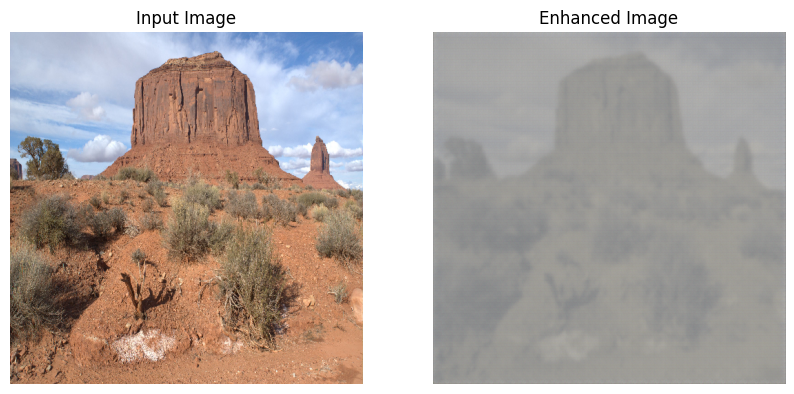

In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image as keras_image

gen = tf.keras.models.load_model('2nd_generator_model_with_pso.h5')

# Function to load and preprocess the input image
def load_and_preprocess_image(img_path):
    img = keras_image.load_img(img_path, target_size=(512, 512))
    img = keras_image.img_to_array(img)
    img = (img / 127.5) - 1  # Scale to [-1, 1]
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to display input and output
def generate_and_show(generator, input_image_path):
    input_image = load_and_preprocess_image(input_image_path)
    prediction = gen(input_image, training=False)

    # Remove batch dimension and scale back to [0, 1]
    input_image = (input_image[0] + 1) / 2
    prediction = (prediction[0] + 1) / 2

    plt.figure(figsize=(10, 5))
    titles = ['Input Image', 'Enhanced Image']
    for i, img in enumerate([input_image, prediction]):
        plt.subplot(1, 2, i + 1)
        plt.title(titles[i])
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# Example usage
generate_and_show(generator, '/kaggle/input/adobe-fivek/raw/a0001-jmac_DSC1459.jpg')
